In [85]:
import numpy as np
import matplotlib.pyplot as plt

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_solver import SpringRodsSystemSolver

from utils.plot_utils import plot_displacements_and_stress

In [86]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular'
})

In [87]:

experiment_setups = [
    {
        'body_forces': lambda x: np.where(x < 0, 1, -1)
    },
    {
        'body_forces': lambda x: np.where(x < 0, -1, 1)
    },
    {
        'body_forces': lambda x: np.where(x < 0, 1, 0)
    },
    {
        'body_forces': lambda x: np.where(x < 0, 0, -1)
    },
    {
        'body_forces': lambda x: np.where(x < 0, 1, 1)
    }
]

In [88]:
experiment_number = 1

In [89]:
model = SpringRodsSystemSetup(
    interval=(-1, 1),
    spring_len=1,
    nodes_num=10,
    material_const=(1, 1),
    spring_const=(1, 1),
    **experiment_setups[experiment_number - 1]
)
solver = SpringRodsSystemSolver(model)

In [90]:
positions = np.concatenate((model.domain[0], model.domain[1]))

In [91]:
spring_const_spectrum = np.linspace(0.01, 100, 100)
spring_const_discrete = [0.1, 1, 10, 100]

In [92]:
results = []

for const in spring_const_discrete:
    model.set_spring_const((const, const))
    displacements = solver()

    stresses = solver.compute_stresses(displacements)
    results.append((displacements, stresses))

In [93]:
# TODO checking if in all test cases spring is compressed or extended
# compressed = []
# for res in results:
#     displ = res[0]
#     left_end_displ = displ[model.nodes_num - 1]
#     right_end_displ = displ[model.nodes_num]
#     compressed.append(left_end_displ - right_end_displ > 0)

# if all(compressed):
#     stiff_coef = '$k_1$'
# elif not any(compressed):
#     stiff_coef = '$k_2$'
# else:
#     print(compressed)
#     print('lack of consistency')
#     print()
#     # raise Exception('lack of consistency')
stiff_coef = 'k'

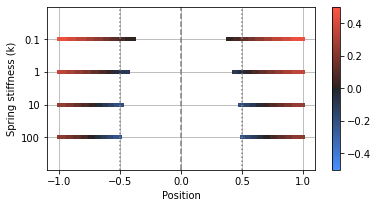

In [94]:
limits = (-0.5, 0.5)
assert abs(np.min([v[1] for v in results])) < 0.5 and abs(np.max([v[1] for v in results])) < 0.5

plot_displacements_and_stress(
    model,
    results,
    spring_const_discrete,
    parameter_name=f'Spring stiffness ({stiff_coef})',
    limits=limits,
    path=f'./plots/spring_stiff_dependence/exp{experiment_number}_full.png'
)

In [95]:
left_end_results = []
right_end_results = []
stress_results = []

for idx, const in enumerate(spring_const_spectrum, 1):
    model.set_spring_const((const, const))
    displacements = solver()

    left_end_results.append(displacements[model.nodes_num - 1])
    right_end_results.append(displacements[model.nodes_num])

    stress = solver.compute_stresses(displacements)
    stress_results.append(stress)

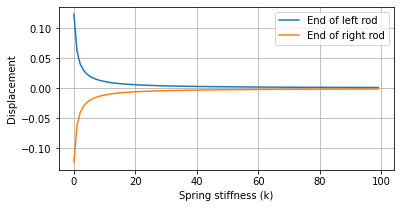

In [96]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

# TODO this is important for experiment 5
if experiment_number == 5:
    plt.ylim(-0.5, 0.5)

plt.plot(left_end_results, label='End of left rod')
plt.plot(right_end_results, label='End of right rod')

plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.ylabel('Displacement')
plt.legend()

plt.savefig(f'plots/exp{experiment_number}_ends_of_rods_displacement.png', bbox_inches='tight')

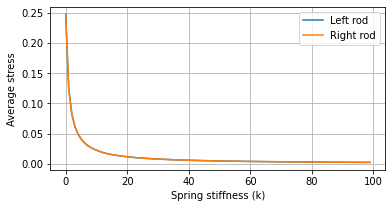

In [97]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

avg_stress_left = [np.average(s[:model.nodes_num-1]) for s in stress_results]
avg_stress_right = [np.average(s[model.nodes_num-1:]) for s in stress_results]
plt.plot(avg_stress_left, label='Left rod')
plt.plot(avg_stress_right, label='Right rod')
plt.ylabel('Average stress')
plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.legend()
plt.savefig(f'plots/exp{experiment_number}_avg_stress.png', bbox_inches='tight')

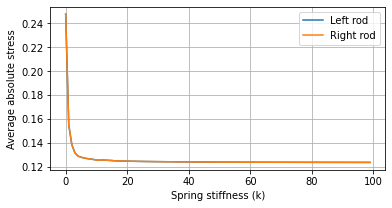

In [98]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

# TODO this is important for experiment 5
if experiment_number == 5:
    plt.ylim(-0.5, 0.5)

avg_stress_left = [np.average(np.abs(s[:model.nodes_num-1])) for s in stress_results]
avg_stress_right = [np.average(np.abs(s[model.nodes_num-1:])) for s in stress_results]
plt.plot(avg_stress_left, label='Left rod')
plt.plot(avg_stress_right, label='Right rod')
plt.ylabel('Average absolute stress')
plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.legend()
plt.savefig(f'plots/exp{experiment_number}_avg_abs_stress.png', bbox_inches='tight')